In [1]:
import numpy as np
from PySDM_examples import Shipway_and_Hill_2012
from PySDM.physics import si
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from skimage.measure import block_reduce

In [2]:
settings = Shipway_and_Hill_2012.Settings(n_sd_per_gridbox=100)
simulation = Shipway_and_Hill_2012.Simulation(settings)
results = simulation.run()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [159]:
def extract_features_one_simulation(simulation_settings, t_block=1, z_block=1):
    simulation = Shipway_and_Hill_2012.Simulation(settings)
    results = simulation.run()
    t_range = results.products["t"]
    z_range = results.products["z"]
    mask = block_reduce(results.products["RH"] > 100, (t_block, z_block), func=np.any).flatten()
    transformation = lambda x: block_reduce(x, (t_block, z_block), func=np.mean).flatten()[mask]
    rho_times_w = np.tile([settings.rho_times_w(t) for t in t_range], (z_range.size, 1))
    feature_vectors = np.vstack([transformation(results.products[attr])
                                 for attr in ("qv", "qc", "qr", "na", "T", "p", "rhod")] +
                                [transformation(rho_times_w)]).T
    activating = transformation(results.products["activating"])
    return feature_vectors, activating

In [160]:
def extract_features(n_simulations, frac_keep=1, t_block=1, z_block=1):
    Xs = []
    Ys = []
    for i in range(n_simulations):
        print("Simulation %d / %d" % (i + 1, n_simulations))
        settings = Shipway_and_Hill_2012.Settings(n_sd_per_gridbox=100, p0=np.random.normal(1007, 50) * si.hPa,
                                                 rho_times_w_1=np.random.normal(2, 0.2) * si.m / si.s * si.kg / si.m**3,
                                                 particles_per_volume_STP=np.random.normal(50, 10) / si.cm**3)
        X1, Y1 = extract_features_one_simulation(settings, t_block, z_block)
        keep_selection = np.random.choice(len(X1), int(len(X1) * frac_keep), replace=False)
        X1 = X1[keep_selection]
        Y1 = Y1[keep_selection]
        Xs.append(X1)
        Ys.append(Y1)
    X = np.concatenate(Xs)
    Y = np.concatenate(Ys)
    perm = np.random.permutation(len(X))
    X = X[perm]
    Y = Y[perm]
    return X, Y

In [161]:
X_train, Y_train = extract_features(1)

Simulation 1 / 1


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [162]:
X_test, Y_test = extract_features(1)

Simulation 1 / 1


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [163]:
regr = GradientBoostingRegressor()
regr.fit(X_train, Y_train)

GradientBoostingRegressor()

In [164]:
def plot_accuracy_scatterplot(X, Y, ax):
    predictions = regr.predict(X)
    ax.set_xlabel("Aerosol Activation (PySDM)")
    ax.set_ylabel("Aerosol Activation (predicted)")
    ax.scatter(Y, predictions, s=1)
    ax.plot([0, max(Y)], [0, max(Y)], color="red", ls="dotted")

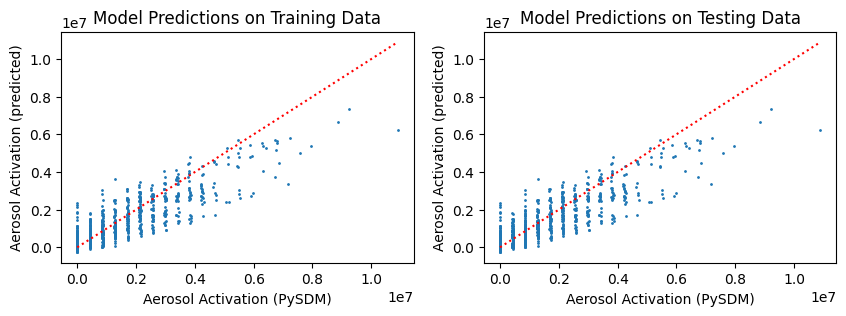

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
axs[0].set_title("Model Predictions on Training Data")
axs[1].set_title("Model Predictions on Testing Data")
axs[1].tick_params(labelleft=True)
plot_accuracy_scatterplot(X_train, Y_train, axs[0])
plot_accuracy_scatterplot(X_test, Y_test, axs[1])